<a href="https://colab.research.google.com/github/msbeigi/Gaussian-process-regression/blob/main/GP-regression-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install openpyxl


import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal
import pandas as pd
import openpyxl
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Kernel


### Loading data

**The EnergyConsumptionData** of 500 points in input-output pairs (i.e., $x_1, y_1, x_2, y_2, . . ., x_{500}, y_{500}$).

In this dataset the first column {𝑥|𝑥 ∈ ℤ ,1 ≤ 𝑥𝑖 ≤ 500} can be used to keep track of the time intervals
between the measurements. The second column is 𝑦 ∈ ℝ, −1.8111 ≤ 𝑦 ≤ 1.7577.
The plot of the data is illustrated in Figure 7, as it is depicted the waveform is sinusoidal, waveform is
a smooth, continuous oscillation between a positive and a negative value. It has a characteristic
shape that is sinusoidal, which means it resembles a curve that repeats itself over time.

In [5]:
#
def read_data(path:str):
    workbook = openpyxl.load_workbook(path)
    sheet = workbook.active
    columnA_values = [cell.value for cell in sheet['A'][0:]]
    columnB_values = [cell.value for cell in sheet['B'][0:]]
    list_dataA = [int(value) for value in columnA_values if value]
    list_dataB = [float(value) for value in columnB_values if value]

    data=pd.concat([pd.DataFrame(list_dataA),pd.DataFrame(list_dataB)],axis=1)
    data.columns=['X', 'Y']
    return data

path='/content/drive/MyDrive/Uni/Aston/Coursework/Probabilistic Modeling/EnergyConsumptionData.xlsx'

df=read_data(path)
df

,X,Y
0,1,0.206510
1,2,0.487440
2,3,0.226630
3,4,0.682970
4,5,0.767300
...,...,...
495,496,-0.034721
496,497,-0.137870
497,498,-0.322240
498,499,-0.131280


### **Simple EDA**

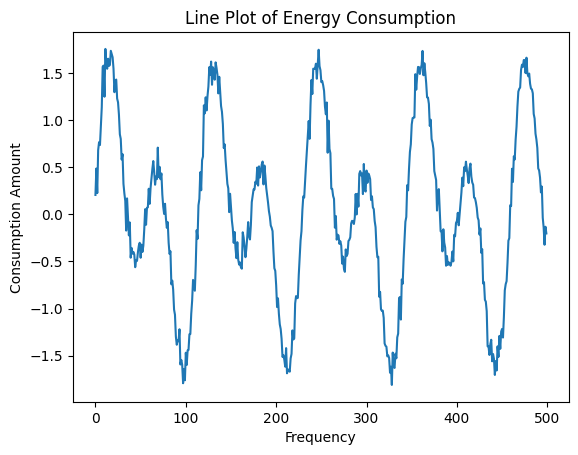

In [6]:
df['Y'].plot()
plt.xlabel('Frequency')
plt.ylabel('Consumption Amount')
plt.title('Line Plot of Energy Consumption')
plt.show()


* Amplitude(A): The amplitude is the height of the wave's crest or the depth of its trough, and it determines the strength or intensity of the signal. This is implemented with ‘np.ptp(y)’, which stands for "peak-to-peak", and it returns the difference between the maximum and minimum values in an array y.

$$
A= \frac{y_{max} -y_{min}}{2}
$$

, where y_max is the maximum value of the wave, and y_min is the minimum value of the
wave.
* The period of is the time it takes for one complete cycle to occur, and it is the reciprocal of the frequency.
*   The frequency of is the number of complete cycles that occur per unit of time (usually seconds), and it determines the pitch of the signal. The Fast Fourier Transform (FFT) is a mathematical algorithm that calculates the Discrete Fourier Transform (DFT) of a sequence or time series data. The DFT is a way to convert a signal from time domain to frequency domain, which means it decomposes the signal into its constituent frequencies.

$$
Y_{k}=Σ^{N-1}_{n=0} y_{n} \exp^{\left(-\frac{2\pi ink}{N}\right)}
$$


In [ ]:
{# dominant freq
x=df['X']
y=df['Y']
fft_y = np.fft.fft(y)
dominant_freq_index = np.argmax(np.abs(fft_y))
dominant_freq = np.fft.fftfreq(len(y))[dominant_freq_index]
# amplitude
amplitude = np.ptp(y)
period = len(y) / dominant_freq

# the phase of the waveform
reference_waveform =amplitude* np.sin(((2 * np.pi)/period) * dominant_freq * x)
correlation = np.correlate(y, reference_waveform, mode='same')
phase = np.argmax(correlation) / len(y) * 360

print('Dominant frequency:', dominant_freq)
print('Amplitude:', amplitude)
print('Period:', period)
print('Phase:', phase)

Dominant frequency: 0.018000000000000002
Amplitude: 3.5688
Period: 27777.777777777774
Phase: 10.799999999999999


In [ ]:
fft = np.fft.fft(y)
freqs = np.fft.fftfreq(len(y))
idx = np.argmax(np.abs(fft))
freq = freqs[idx]
amp = np.abs(fft[idx])
print('frequency:', freq)

frequency: 0.018000000000000002


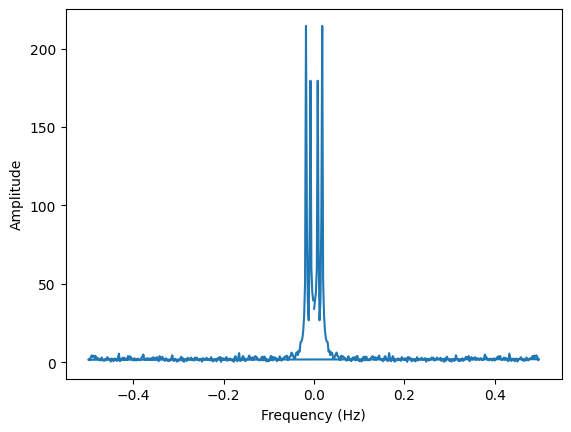

In [ ]:
plt.plot(freqs, np.abs(fft))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

In [20]:
X=df['X']
Y=df['Y']
X_train,X_test,y_train, y_test= train_test_split(X,Y,test_size=0.35,shuffle=False)

### Modeling (GP Kernel and class)

**c)**
**My Sample Kernel**
model the data use the kernel that combines two components i = 1, 2.
kernel :
$$
\begin{aligned}
C(x, x'; \Theta) = \theta \exp\left[-\frac{1}{2} \sum_{i=1}^2 \left(\frac{\sin\left(\frac{\pi}{\lambda_i}(x - x')\right)}{r_i}\right)^2\right],
\end{aligned}
$$

the gradients with respect to $\theta$, $\lambda_i$, and $r_i$:

Gradient with respect to $\theta$:
\begin{align}
\frac{\partial C(x, x'; \Theta)}{\partial \theta} = \exp\left[-\frac{1}{2} \sum_{i=1}^2 \left(\frac{\sin\left(\frac{\pi}{\lambda_i}\left(x - x'\right)\right)}{r_i}\right)^2\right]
\end{align}

Gradient with respect to $\lambda_i$:
\begin{align}
\frac{\partial C(x, x'; \Theta)}{\partial \lambda_i} = \theta \exp\left[-\frac{1}{2} \sum_{i=1}^2 \left(\frac{\sin\left(\frac{\pi}{\lambda_i}(x - x')\right)}{r_i}\right)^2\right] \left(\frac{\pi \left(x - x'\right) \cos\left(\frac{\pi}{\lambda_i}\left(x - x'\right)\right)}{\lambda_i^2 r_i^2}\right)
\end{align}

Gradient with respect to $r_i$:
\begin{align}
\frac{\partial C(x, x'; \Theta)}{\partial r_i} = \theta \exp\left[-\frac{1}{2} \sum_{i=1}^2 \left(\frac{\sin\left(\frac{\pi}{\lambda_i}(x - x')\right)}{r_i}\right)^2\right] \left(\frac{\sin\left(\frac{\pi}{\lambda_i}\left(x - x'\right)\right)}{r_i^3}\right)
\end{align}



* $\theta$: The amplitude parameter controls the overall amplitude of the kernel function. It determines
how much influence the data points have on each other. In other words, it determines how much variation the model is allowed to exhibit. A larger  means the function will vary more.
* $\lambda_i$: The length scale parameter controls the smoothness of the kernel function. It determines the
scale at which the data points are assumed to be correlated. The length scale controls the smoothness of the function being learned by the Gaussian process regressor. A small length scale
will result in a very wiggly, high-frequency function, while a large length scale will result in a smoother, low-frequency function.
* $r_i$ : The scaling factor controls the vertical scale of the kernel function. It determines the overall
magnitude of the function.



In [8]:


class GaussianProcess:
    def __init__(self, theta= 3.5688 , lambda_1=-0.001, lambda_2=0.1, r_1=0.2802, r_2=0.2898):
        self.theta = theta
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.r_1 = r_1
        self.r_2 = r_2

    def kernel(self, x1, x2):
        sin_term_1 = np.sin(np.pi / self.lambda_1 * (x1 - x2)) / self.r_1
        sin_term_2 = np.sin(np.pi / self.lambda_2 * (x1 - x2)) / self.r_2
        kernel_value = self.theta * np.exp(-0.5 * (sin_term_1 ** 2 + sin_term_2 ** 2))
        return kernel_value

    def fit(self, X, y,noise=1e-8):
        self.X_train = X
        self.y_train = y
        n = len(X)
        self.K = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                self.K[i, j] = self.kernel(X[i], X[j])
        self.K += noise * np.eye(n)

    def predict(self, X_star):
        n = len(self.X_train)
        m = len(X_star)
        K_star = np.zeros((m, n))
        for i in range(m):
            for j in range(n):
                K_star[i, j] = self.kernel(X_star[i], self.X_train[j])
        K_star_star = np.zeros((m, m))
        for i in range(m):
            for j in range(m):
                K_star_star[i, j] = self.kernel(X_star[i], X_star[j])
        K_inv = np.linalg.inv(self.K)
        y_mean = np.dot(np.dot(K_star, K_inv), self.y_train)
        y_cov = K_star_star - np.dot(np.dot(K_star, K_inv), K_star.T)
        return y_mean, y_cov



#### Train & predict

Since the dominant frequency is 0.018000000000000002, we can initialize $\lambda{1}$ to a value close
to $\frac{1} {0.018} = 55.56$. Similarly, since the sine repeats after about 113 periods, it can  be initialized $\lambda{2}$ to
a value close to 113.

In [9]:
y_noise = y_train + np.random.normal(loc=0, scale=0.1, size=X_train.shape[0])

X_=X_train.reset_index(drop=True)
y_=y_train.reset_index(drop=True)
gp = GaussianProcess(theta= 3.5688 , r_1=1.5556, r_2=3.6,lambda_1=55.55, lambda_2=113)

gp.fit(X_, y_noise.reset_index(drop=True))
y_mean, y_cov = gp.predict(X_test.reset_index(drop=True))

In [ ]:
y_cov

array([[ -4.35572772,  -4.37118072,  -4.39080629, ...,  -6.11365831,
         -6.07274146,  -6.02124766],
       [ -6.27162894,  -6.26521515,  -6.28296819, ...,  -9.6454234 ,
         -9.44808909,  -9.22874142],
       [ -3.28294666,  -3.15658574,  -3.04539494, ...,  -8.04625007,
         -8.08219275,  -8.0894171 ],
       ...,
       [ -1.98426343,  -1.97445078,  -1.98333157, ...,  -6.23059522,
         -6.16896289,  -6.09029032],
       [ -7.40278583,  -7.36026581,  -7.34336759, ..., -12.06865247,
        -11.96031554, -11.83228007],
       [ 40.02012055,  39.47250415,  38.93059313, ...,  45.24076116,
         45.77885697,  46.23825587]])

In [ ]:
y_mean

array([-1.26274940e+01, -3.80701606e+01, -7.58468733e+01, -1.30899507e+02,
       -2.03141738e+02, -2.77463472e+02, -3.59297393e+02, -4.37445169e+02,
       -5.17607202e+02, -5.87654663e+02, -6.47014508e+02, -6.92775799e+02,
       -7.23096081e+02, -7.28672265e+02, -7.06751365e+02, -6.56835853e+02,
       -5.88375603e+02, -5.06875482e+02, -3.99534188e+02, -2.87924527e+02,
       -1.76748382e+02, -6.14031018e+01,  3.44389246e+01,  1.14970667e+02,
        1.77154958e+02,  2.12637043e+02,  2.24796929e+02,  2.09398368e+02,
        1.77120602e+02,  1.24910940e+02,  6.04232988e+01, -1.62633353e+01,
       -9.98683572e+01, -2.02622929e+02, -3.08922848e+02, -4.28238962e+02,
       -5.52016597e+02, -6.77285892e+02, -7.90141218e+02, -8.94660268e+02,
       -9.85208407e+02, -1.05547024e+03, -1.10534498e+03, -1.13436913e+03,
       -1.14584658e+03, -1.13759444e+03, -1.10615073e+03, -1.06071954e+03,
       -9.96507987e+02, -9.17720379e+02, -8.22558328e+02, -7.17341027e+02,
       -6.04801988e+02, -

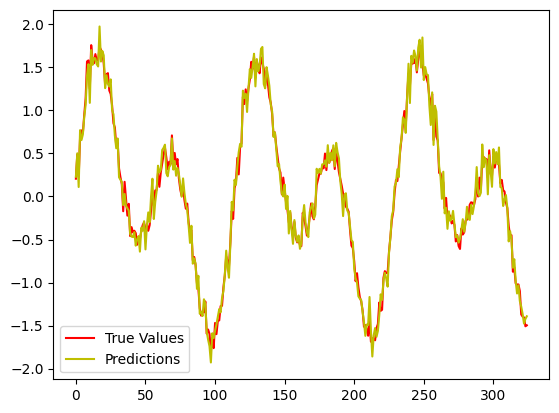

In [11]:
plt.plot(y_train,'r-', label='True Values')
plt.plot(y_noise, 'y-', label='Predictions')
plt.legend()
plt.show()


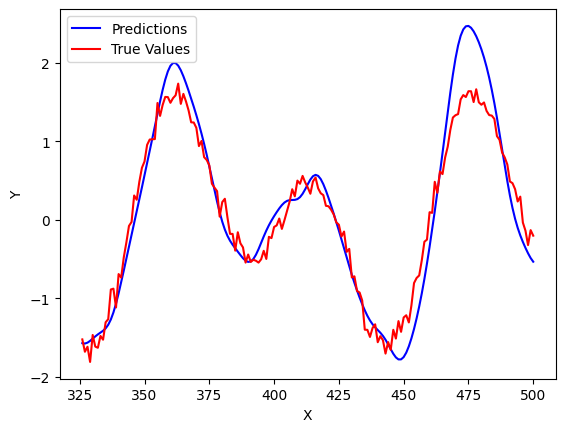

In [ ]:

plt.plot(X_test, y_mean, 'b-', label='Predictions')
plt.plot(X_test, y_test, 'r-', label='True Values')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

#### Adding noise to target(normal distribution based)

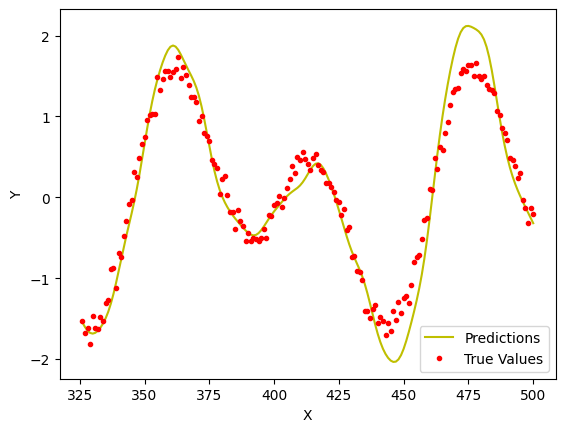

In [12]:
y_noise = y_train + np.random.normal(loc=0, scale=0.1, size=X_train.shape[0])

X_=X_train.reset_index(drop=True)
y_=y_train.reset_index(drop=True)
gp_ii = GaussianProcess(theta= 0.7369 , r_1=0.2802, r_2=0.2898,lambda_1=-0.2278, lambda_2=-0.2278)

gp_ii.fit(X_, y_noise.reset_index(drop=True))
y_pred_ii, y_cov_ii = gp.predict(X_test.reset_index(drop=True))

plt.plot(X_test, y_pred_ii, 'y-', label='Predictions')
plt.plot(X_test, y_test, 'r.', label='True Values')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

#### **Quadratic error**


In [ ]:
n = len(y)
sq_diff = np.square(y_test - y_mean)
E = np.sum(sq_diff) / n
print('expected quadratic error:',E)

expected quadratic error: 0.03452871783352929


In [ ]:
from sklearn.metrics import mean_squared_error
mse= mean_squared_error(y_test, y_mean)
print('mean squared error:',mse)


mean squared error: 0.09865347952436938


#### **Comparison with classic GP model**

In [ ]:


gp = GaussianProcess()
gp.fit(X_, y_noise)
x_star = np.array([[150]])
y_mean, y_cov = gp.predict(x_star)
expected_y = y_mean[0]
print(f'expected:{expected_y} \ntrue value:{y_[150]}')

expected:0.07505809317862024 
true value:0.07814


**Gaussian model with default setting**

In [15]:
from sklearn.gaussian_process import GaussianProcessRegressor

gpr = GaussianProcessRegressor()
gpr.fit(X_.values.reshape(-1, 1), y_.values.reshape(-1, 1))
y_pred_in = gpr.predict(X_test.values.reshape(-1, 1))


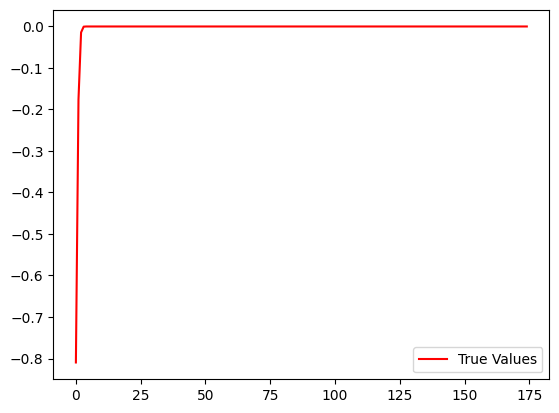

In [16]:
# y_pred_in
plt.plot(y_pred_in,'r-', label='True Values')
plt.legend()

**Gaussian model with exponential sine kernel**

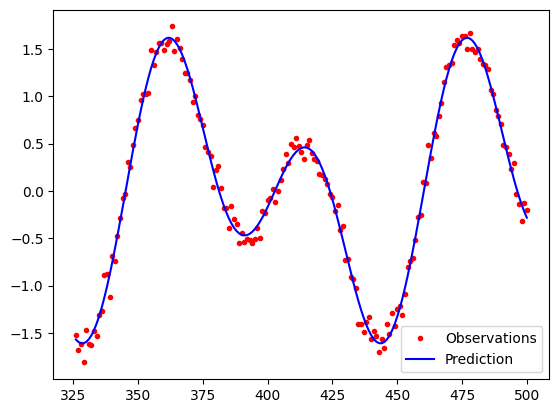

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared
# finding a periodicity (theta) palys a key role in prediction
kernel = ExpSineSquared(length_scale=1.0, periodicity=0.7369)
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.1)
gp.fit(X_train.values.reshape(-1, 1), y_train.values.reshape(-1, 1))
y_pred, y_std = gp.predict(X_test.values.reshape(-1, 1), return_std=True)
plt.plot(X_test,y_test, 'r.', label='Observations')
plt.plot(X_test, y_pred, 'b-', label='Prediction')
plt.legend()
plt.show()
